# 📊 NSE Portfolio Builder & Optimizer

**Portfolio Management System Using Modern Portfolio Theory**

---

**Author:** Parth Nema  
**GitHub:** [github.com/parthnemaa/nse-portfolio-builder](https://github.com/parthnemaa/nse-portfolio-builder)  
**Last Updated:** October 2025

---

## 🔱 Project Overview

This notebook demonstrates:
- **Data Engineering**: Fetching live NSE stock data via APIs
- **Portfolio Optimization**: Monte Carlo simulation & efficient frontier
- **Risk Analytics**: Sharpe ratio, Sortino ratio, max drawdown, CAGR
- **Backtesting**: Performance comparison vs NIFTY 50 benchmark
- **Business Insights**: Actionable investment recommendations


## 💼 Business Problem Statement

### Challenge
Retail investors lack systematic tools to:
- Construct diversified portfolios from 2000+ NSE stocks
- Optimize risk-return tradeoffs quantitatively
- Backtest strategies against market benchmarks

### Solution Approach
Apply **Modern Portfolio Theory** (Markowitz optimization) to:
1. Select top stocks by market capitalization
2. Calculate risk-return metrics using historical data
3. Generate efficient frontier via Monte Carlo simulation
4. Identify optimal portfolio allocations
5. Validate performance through backtesting

### Expected Outcomes
- Higher risk-adjusted returns (Sharpe ratio > 1)
- Reduced volatility through diversification
- Outperformance vs NIFTY 50 benchmark

---


In [3]:
# Data fetching and processing
from nsepython import nse_eq_symbols  # NSE stock symbols
import yfinance as yf                 # Yahoo Finance API for stock data
import pandas as pd
import numpy as np

# Portfolio optimization
from scipy.optimize import minimize

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Utilities
import math
import locale
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [7]:
# Fetch all NSE equity symbols
print("Fetching NSE equity symbols...")
nse_symbols = nse_eq_symbols()
print(f"✓ Total NSE equity symbols fetched: {len(nse_symbols)}")
print(f"\nSample symbols: {nse_symbols[:10]}")

Fetching NSE equity symbols...
✓ Total NSE equity symbols fetched: 2191

Sample symbols: ['20MICRONS', '21STCENMGM', '360ONE', '3IINFOLTD', '3MINDIA', '3PLAND', '5PAISA', '63MOONS', 'A2ZINFRA', 'AAATECH']


In [8]:
# Prepare tickers for Yahoo Finance
nse_tickers = [s + ".NS" for s in nse_symbols]
print(f"✓ Prepared {len(nse_tickers)} tickers for yfinance")
print(f"\nSample yfinance tickers: {nse_tickers[:10]}")

✓ Prepared 2191 tickers for yfinance

Sample yfinance tickers: ['20MICRONS.NS', '21STCENMGM.NS', '360ONE.NS', '3IINFOLTD.NS', '3MINDIA.NS', '3PLAND.NS', '5PAISA.NS', '63MOONS.NS', 'A2ZINFRA.NS', 'AAATECH.NS']


In [9]:
def fetch_stock_fundamentals(tickers, batch_size=100):
    """
    Fetch fundamentals for given tickers in batches
    Returns DataFrame
    """
    fundamentals = []
    total = len(tickers)
    print(f"Fetching fundamentals for {total} stocks... This will take a while.")
    for i in range(0, total, batch_size):
        batch = tickers[i:i+batch_size]
        for ticker in batch:
            try:
                stock = yf.Ticker(ticker)
                info = stock.info
                fundamentals.append({
                    'Ticker': ticker,
                    'Company Name': info.get('longName', 'N/A'),
                    'Price': info.get('currentPrice', np.nan),
                    'Market Cap': info.get('marketCap', np.nan),
                    'P/E Ratio': info.get('trailingPE', np.nan),
                    'Sector': info.get('sector', 'N/A')
                })
            except Exception:
                continue
        print(f"Fetched {min(i + batch_size, total)}/{total} stocks")
    df = pd.DataFrame(fundamentals)
    print(f"\n✓ Fundamentals fetched for {len(df)} stocks.")
    return df

fundamentals_df = fetch_stock_fundamentals(nse_tickers[:])

Fetching fundamentals for 2191 stocks... This will take a while.
Fetched 100/2191 stocks
Fetched 200/2191 stocks
Fetched 300/2191 stocks
Fetched 400/2191 stocks


HTTP Error 404: 


Fetched 500/2191 stocks
Fetched 600/2191 stocks
Fetched 700/2191 stocks
Fetched 800/2191 stocks
Fetched 900/2191 stocks
Fetched 1000/2191 stocks
Fetched 1100/2191 stocks
Fetched 1200/2191 stocks
Fetched 1300/2191 stocks
Fetched 1400/2191 stocks
Fetched 1500/2191 stocks
Fetched 1600/2191 stocks
Fetched 1700/2191 stocks
Fetched 1800/2191 stocks
Fetched 1900/2191 stocks
Fetched 2000/2191 stocks
Fetched 2100/2191 stocks
Fetched 2191/2191 stocks

✓ Fundamentals fetched for 2191 stocks.


In [11]:
# Top 50 stocks by market capitalization
fundamentals_df = fundamentals_df.dropna(subset=["Market Cap", "Price"])
top_50 = fundamentals_df.nlargest(50, 'Market Cap').reset_index(drop=True)
print(f"Selected Top 50 stocks with combined market cap: ₹{top_50["Market Cap"].sum()/1e12:.2f} trillion")
top_50.head(10)

Selected Top 50 stocks with combined market cap: ₹218.77 trillion


,Ticker,Company Name,Price,Market Cap,P/E Ratio,Sector
0,RELIANCE.NS,Reliance Industries Limited,1451.60,19643735474176.00,23.64,Energy
1,HDFCBANK.NS,HDFC Bank Limited,994.75,15283005685760.00,22.73,Financial Services
2,BHARTIARTL.NS,Bharti Airtel Limited,2029.30,12168924758016.00,34.37,Communication Services
3,TCS.NS,Tata Consultancy Services Limited,3063.20,11082925080576.00,22.42,Technology
4,ICICIBANK.NS,ICICI Bank Limited,1377.70,9843569065984.00,18.66,Financial Services
5,SBIN.NS,State Bank of India,904.50,8349093462016.00,10.16,Financial Services
6,BAJFINANCE.NS,Bajaj Finance Limited,1089.75,6772943224832.00,38.91,Financial Services
7,INFY.NS,Infosys Limited,1525.40,6323255640064.00,22.03,Technology
8,HINDUNILVR.NS,Hindustan Unilever Limited,2516.40,5914860453888.00,54.35,Consumer Defensive
9,LICI.NS,Life Insurance Corporation of India,889.65,5627034206208.00,11.55,Financial Services


In [12]:
# Fetch historical close prices for last 3 years
end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)
print(f"Fetching historical price data from {start_date.date()} to {end_date.date()}...")
price_data = yf.download(top_50['Ticker'].tolist(), start=start_date, end=end_date)['Close']

# Remove stocks with >20% missing data
min_data_points = len(price_data) * 0.8
price_data = price_data.dropna(axis=1, thresh=int(min_data_points))
print(f"Data fetched for {price_data.shape[1]} stocks with {price_data.shape[0]} days of data.")

Fetching historical price data from 2022-10-26 to 2025-10-25...


[*********************100%***********************]  50 of 50 completed


Data fetched for 48 stocks with 740 days of data.


In [15]:
print(price_data.shape)
print(price_data.head(10))
print(price_data.tail(10))
print(price_data.isnull().sum())

(740, 48)
Ticker      ADANIENT.NS  ADANIPORTS.NS  ADANIPOWER.NS  ASIANPAINT.NS  \
Date                                                                   
2022-10-27      3320.30         808.35          67.48        2952.47   
2022-10-28      3318.60         807.41          66.66        2962.12   
2022-10-31      3342.72         810.61          66.98        3019.15   
2022-11-01      3570.65         828.58          69.78        3069.38   
2022-11-02      3575.64         820.31          68.63        3042.66   
2022-11-03      3585.33         820.75          67.35        3051.79   
2022-11-04      3827.83         849.34          69.37        3090.70   
2022-11-07      3955.00         839.60          69.72        3015.12   
2022-11-09      3991.55         876.81          73.16        2998.56   
2022-11-10      3986.61         879.41          74.28        2958.38   

Ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  BEL.NS  \
Date                                         

In [16]:
# Calculate daily returns
daily_returns = price_data.pct_change().dropna()
daily_returns.describe().T[['mean', 'std']].head(10)

,mean,std
Ticker,,
ADANIENT.NS,0.00,0.03
ADANIPORTS.NS,0.00,0.02
ADANIPOWER.NS,0.00,0.03
ASIANPAINT.NS,-0.00,0.01
AXISBANK.NS,0.00,0.01
BAJAJ-AUTO.NS,0.00,0.02
BAJAJFINSV.NS,0.00,0.01
BAJFINANCE.NS,0.00,0.02
BEL.NS,0.00,0.02


In [17]:
def portfolio_performance(weights, returns, cov, risk_free=0.06):
    port_return = np.sum(returns.mean() * weights) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe = (port_return - risk_free) / port_vol
    return port_return, port_vol, sharpe

cov_matrix = daily_returns.cov()

print(f"Covariance matrix size: {cov_matrix.shape}")

Covariance matrix size: (48, 48)


In [18]:
# Equal weight portfolio
n = price_data.shape[1]
weights_eq = np.repeat(1/n, n)
ret_eq, vol_eq, sharpe_eq = portfolio_performance(weights_eq, daily_returns, cov_matrix)
print(f"Equal weight portfolio - Annual return: {ret_eq:.2%}")
print(f"Equal weight portfolio - Annual volatility: {vol_eq:.2%}")
print(f"Equal weight portfolio - Sharpe ratio: {sharpe_eq:.2f}")

Equal weight portfolio - Annual return: 23.36%
Equal weight portfolio - Annual volatility: 13.80%
Equal weight portfolio - Sharpe ratio: 1.26


In [19]:
# Monte Carlo simulation
np.random.seed(42)
n_portfolios = 10000
results = np.zeros((3, n_portfolios))
weights_record = np.zeros((n_portfolios, n))
for i in range(n_portfolios):
    weights = np.random.random(n)
    weights /= sum(weights)
    weights_record[i] = weights
    ret, vol, sharpe = portfolio_performance(weights, daily_returns, cov_matrix)
    results[0,i] = ret
    results[1,i] = vol
    results[2,i] = sharpe
max_sharpe_idx = results[2].argmax()
min_vol_idx = results[1].argmin()
print(f"Max Sharpe portfolio return: {results[0,max_sharpe_idx]:.2%}, volatility: {results[1,max_sharpe_idx]:.2%}")

Max Sharpe portfolio return: 27.63%, volatility: 13.87%


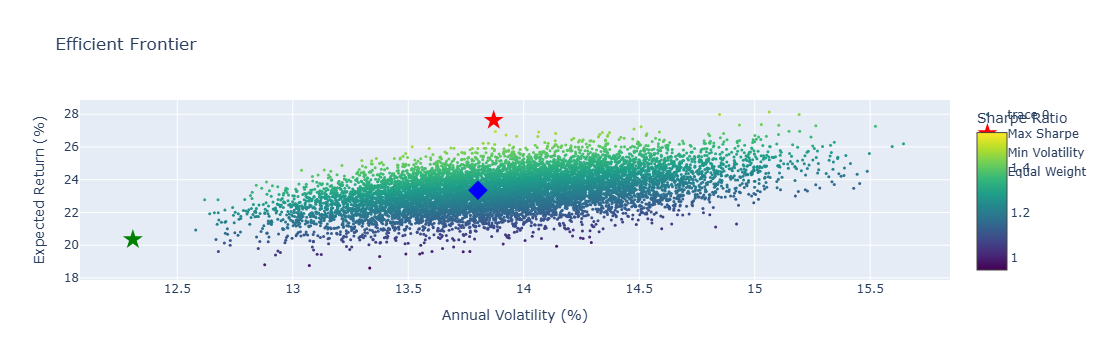

In [23]:
# Visualize efficient frontier
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=results[1]*100, y=results[0]*100, mode='markers',
                         marker=dict(color=results[2], colorscale='Viridis', size=3, colorbar=dict(title='Sharpe Ratio'))))
fig.add_trace(go.Scatter(x=[results[1,max_sharpe_idx]*100], y=[results[0,max_sharpe_idx]*100],
                         mode='markers', marker=dict(color='red', size=15, symbol='star'), name='Max Sharpe'))
fig.add_trace(go.Scatter(x=[results[1,min_vol_idx]*100], y=[results[0,min_vol_idx]*100],
                         mode='markers', marker=dict(color='green', size=15, symbol='star'), name='Min Volatility'))
fig.add_trace(go.Scatter(x=[vol_eq*100], y=[ret_eq*100], mode='markers', name='Equal Weight', marker=dict(color='blue', size=15, symbol='diamond')))
fig.update_layout(title='Efficient Frontier', xaxis_title='Annual Volatility (%)', yaxis_title='Expected Return (%)')
fig.show()

In [21]:
# Optimal portfolio weights
opt_weights = weights_record[max_sharpe_idx]
opt_portfolio = pd.DataFrame({
    'Ticker': daily_returns.columns,
    'Weight': opt_weights
}).sort_values(by='Weight', ascending=False)
opt_portfolio['Weight %'] = opt_portfolio['Weight']*100
opt_portfolio.head(10)

,Ticker,Weight,Weight %
14,EICHERMOT.NS,0.05,4.90
11,DIVISLAB.NS,0.05,4.56
8,BEL.NS,0.05,4.50
38,RELIANCE.NS,0.04,4.50
22,HINDZINC.NS,0.04,4.49
15,ETERNAL.NS,0.04,4.29
45,ULTRACEMCO.NS,0.04,3.95
9,BHARTIARTL.NS,0.04,3.90
24,INDIGO.NS,0.04,3.86
28,JSWSTEEL.NS,0.03,3.39


## 👀 Correlation Heatmap

Visualize correlation between top stocks to assess diversification benefits.

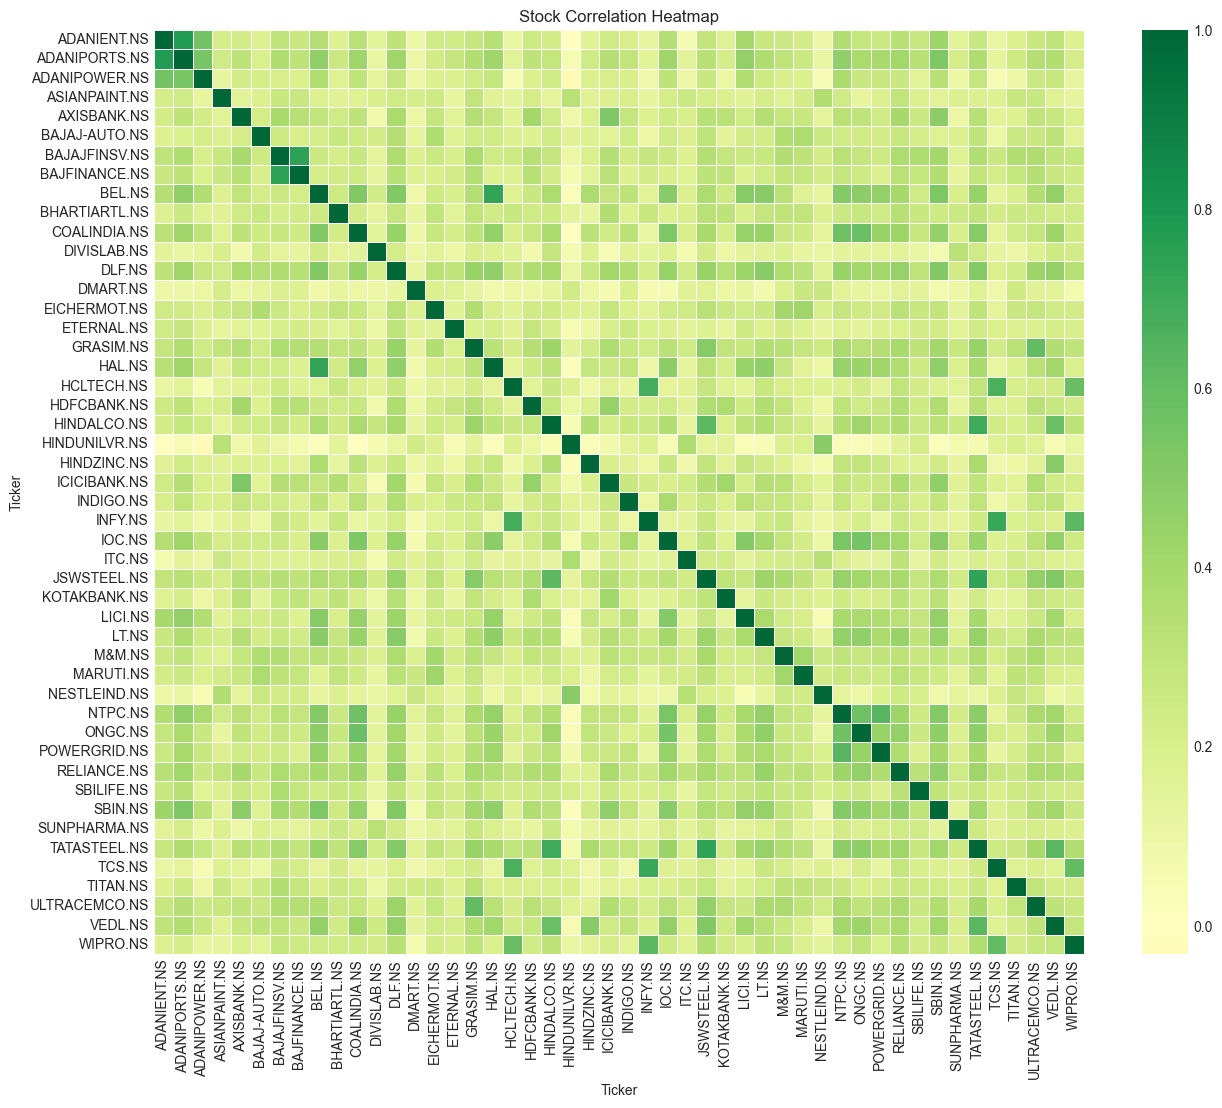

In [22]:
corr_matrix = daily_returns.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='RdYlGn', center=0, linewidths=0.5)
plt.title('Stock Correlation Heatmap')
plt.show()